# Avis Restau : improve the AI product of your start-up

## Context

"Avis Restau" is a start-up who's goal is to connect restaurants and customers. Customers will be able to post photos and reviews of the restaurants they have visited.

The goal here is to identify topics of bad customer reviews and to label photos as indoor or outdoor , food or drink, ...


## Load project modules

The helpers functions and project specific code will be placed in `../src/`.

We will use the [Python](https://www.python.org/about/gettingstarted/) programming language, and present here the code and results in this [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) file.

We will use the usual libraries for data exploration, modeling and visualisation :

-   [NumPy](https://numpy.org/doc/stable/user/quickstart.html) and [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : for maths (stats, algebra, ...) and large data manipulation
-   [scikit-learn](https://scikit-learn.org/stable/getting_started.html) : for machine learning models training and evaluation
-   [Plotly](https://plotly.com/python/getting-started/) : for interactive data visualization

We will also use libraries specific to the goals of this project :

-   NLP (Natural Language Processing)
    -   [NLTK](https://www.nltk.org/) and [Spacy](https://spacy.io/api) : for text processing
    -   [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html) and [pyLDAvis](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) : for topic modelling and visualisation
-   CV (Computer Vision)
    -   [scikit-image](https://scikit-image.org/docs/stable/overview.html) and [OpenCV](https://docs.opencv.org/4.x/index.html) : for image processing
    -   [Keras](https://keras.io/getting_started/) : for neural network models training and evaluation


In [1]:
# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import random


# ML modules
import pandas as pd
import numpy as np


# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 10 * 1000  # <= 0 for all


## Load dataset from Yelp's API

We will use Yelp's GraphQL API to get the data. We will load the Reviews (~3 reviews per restaurant) and Photos (1 photo per restaurant) of 1000 restaurants from 5 locations (200 restaurants per location).


### Download the dataset to CSV

We download the dataset from the Yelp GraphQL API.

In [2]:
# Download and unzip CSV files
!cd .. && make dataset && cd notebooks


>>> Downloading and saving data files...
python -m src.data.make-dataset -t data/raw/api/
INFO:root:Data already downloaded
>>> OK.



### Load the dataset from CSV

In [3]:
DATA_PATH = "../data/raw/api/"

businesses_csv_path = os.path.join(DATA_PATH, "businesses.csv")
reviews_csv_path = os.path.join(DATA_PATH, "reviews.csv")
photos_csv_path = os.path.join(DATA_PATH, "photos.csv")

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data found, loading from {DATA_PATH}")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.error("Data not found, please run `make dataset`")

# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df[
    "business_review_count"
].astype(int)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(
    float
)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df[
    "business_postal_code"
].astype(str)
businesses_df["business_country"] = businesses_df["business_country"].astype(
    str
)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(
    float
)
businesses_df["business_longitude"] = businesses_df[
    "business_longitude"
].astype(float)
businesses_df["business_categories"] = businesses_df[
    "business_categories"
].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)
photos_df["file_name"] = photos_df["file_name"].astype(str)

# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


INFO:root:Data found, loading from ../data/raw/api/
INFO:root:Memory usage of dataframe is 0.09 MB
INFO:root:Memory usage after optimization is 0.05 MB
INFO:root:Decreased by 44 %
INFO:root:Memory usage of dataframe is 0.07 MB
INFO:root:Memory usage after optimization is 0.06 MB
INFO:root:Decreased by 14 %
INFO:root:Memory usage of dataframe is 0.02 MB
INFO:root:Memory usage after optimization is 0.02 MB
INFO:root:Decreased by 0 %


### Exploratory Data Analysis

We will just display here a few statistics about each DataFrame.

#### Businesses

The dataset is composed of 1000 businesses from 5 locations (Paris, New York, Tokyo, Rio de Janeiro and Sydney). Each business has a unique ID, a name, a category, an average rating, a price category, a city, a state, a country, a postal code, a latitude and a longitude.


In [4]:
businesses_df.head()


business_alias  business_review_count  \
0  le-comptoir-de-la-gastronomie-paris                   1107   
1               l-as-du-fallafel-paris                   1810   
2                       angelina-paris                   1347   
3             l-avant-comptoir-paris-3                    612   
4               la-coïncidence-paris-4                    493   

   business_rating  business_price business_city business_state  \
0              4.5               2         Paris             75   
1              4.5               1         Paris             75   
2              4.0               3         Paris             75   
3              4.5               2         Paris             75   
4              4.5               2         Paris             75   

  business_postal_code business_country  business_latitude  \
0                75001               FR          48.864517   
1                75004               FR          48.857498   
2                75001               FR          48.865093   
3                75006               FR          48.852020   
4                75116               FR          48.868107   

   business_longitude                      business_categories  \
0            2.345402                               ["french"]   
1            2.359080      ["kosher", "falafel", "sandwiches"]   
2            2.328464  ["tea", "cakeshop", "breakfast_brunch"]   
3            2.338800                   ["wine_bars", "tapas"]   
4            2.284365                               ["french"]   

         business_parent_categories  
0                   ["restaurants"]  
1  ["restaurants", "mediterranean"]  
2           ["restaurants", "food"]  
3           ["bars", "restaurants"]  
4                   ["restaurants"]

In [5]:
businesses_df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude business_categories business_parent_categories  
count          1000.000000                1000                       1000  
unique                 NaN                 530                         50  
top                    NaN          ["french"]            ["restaurants"]  
freq                   NaN                  56                        551  
mean             35.219700                 NaN                        NaN  
std              93.358452                 NaN                        NaN  
min             -74.016022                 NaN                        NaN  
25%             -43.218462                 NaN                        NaN  
50%               2.340317                 NaN                        NaN  
75%             139.770420                 NaN                        NaN  
max             151.298248                 NaN                        NaN

In [6]:
fig = px.histogram(
    businesses_df, x="business_rating", marginal="box", color="business_country"
)
fig.show()


In [7]:
fig = px.histogram(
    businesses_df, x="business_price", marginal="box", color="business_country"
)
fig.show()


We can see that French and Japanese restaurants have higher review ratings, but Japanese restaurants are less expensive than french ones.

There are no empty values or outliers.


In [8]:
# Encode categories
df = feat_helpers.one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)


In [9]:
# Plot the correlation of categories with rating
corr_rating = (
    df[
        ["business_rating", "business_price"]
        + [col for col in df.columns if col.startswith("business_categories")]
    ]
    .corr()[["business_rating"]]
    .drop("business_rating")
    .sort_values(
        by=["business_rating"],
        ascending=False,
    )
)


fig = px.bar(corr_rating.head(10).append(corr_rating.tail(10)), color="value")
fig.update_layout(
    title="Top 20 Correlations with Business Rating",
    xaxis_title="Category",
    yaxis_title="Correlation",
)
fig.show()


In [10]:
# Plot the correlation of categories with prince
corr_price = (
    df[
        ["business_price", "business_rating"]
        + [col for col in df.columns if col.startswith("business_categories")]
    ]
    .corr()[["business_price"]]
    .drop("business_price")
    .sort_values(
        by=["business_price"],
        ascending=False,
    )
)


fig = px.bar(corr_price.head(10).append(corr_price.tail(10)), color="value")
fig.update_layout(
    title="Top 20 Correlations with Business Price",
    xaxis_title="Category",
    yaxis_title="Correlation",
)
fig.show()


Overall, pricy restaurants tend to have lower review ratings : people are more picky when they spend more money.
The correlations confirm that French restaurants are overpriced (high positive correlation to the Price), while Japanese restaurants are cheap (high negative correlation to the Price). Ramen restaurants seem to be the best value for money deals (un the top 10 Ratings and bottom 10 Prices).


#### Reviews

The dataset is composed of 2928 reviews from 1000 businesses (~3 reviews per business). Each review has a business alias, a text and a rating.


In [11]:
reviews_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1  le-comptoir-de-la-gastronomie-paris   
2  le-comptoir-de-la-gastronomie-paris   
3               l-as-du-fallafel-paris   
4               l-as-du-fallafel-paris   

                                         review_text  review_rating  
0  This review is from our 2019 trip.  Shame on m...            5.0  
1  This place def lives up the hype.  Best French...            5.0  
2  While planning a friends trip to Paris, I came...            5.0  
3  This is the best falafel sandwich I have ever ...            5.0  
4  IMO this is a must try in Paris. 

Located in ...            5.0

In [12]:
reviews_df.describe(include="all")


business_alias  \
count                                  2928   
unique                                  990   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      3   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              review_text  review_rating  
count                                                2928    2928.000000  
unique                                               2928            NaN  
top     This review is from our 2019 trip.  Shame on m...            NaN  
freq                                                    1            NaN  
mean                                                  NaN       4.396516  
std                                                   NaN       0.904879  
min                                                   NaN       1.000000  
25%                                                   NaN       4.000000  
50%                                                   NaN       5.000000  
75%                                                   NaN       5.000000  
max                                                   NaN       5.000000

In [13]:
fig = px.histogram(reviews_df, x="review_rating", marginal="box")
fig.show()


We can see that reviews are highly skewed towards the high grades : more than half of the reviews are 5 stars.

There are no empty values or outliers.


In [14]:
ratings_diff = reviews_df.join(
    businesses_df.set_index("business_alias")[["business_rating"]],
    on="business_alias",
)
reviews_df["rating_diff"] = (
    ratings_diff["review_rating"] - ratings_diff["business_rating"]
)
reviews_df["rating_sentiment"] = (reviews_df["rating_diff"] > 0).astype(int)


reviews_df[["rating_diff", "rating_sentiment"]].describe()


rating_diff  rating_sentiment
count  2928.000000       2928.000000
mean      0.125683          0.572404
std       0.875052          0.494814
min      -3.500000          0.000000
25%      -0.500000          0.000000
50%       0.500000          1.000000
75%       0.500000          1.000000
max       2.000000          1.000000

In [15]:
fig = px.histogram(
    reviews_df,
    x="rating_diff",
    marginal="box",
    title="Rating Difference : Review - Business average",
    color=reviews_df["rating_sentiment"],
)
fig.show()


We can see that in our Reviews dataset, ratings are a bit higher than the average ratings from the Businesses dataset.

For the rest of this analysis, we will consider the difference of rating between a review and the average rating of the business. A review is considered as a positive review if the rating is higher than the average rating of the business, and a negative review if the rating is lower or equal to the average rating of the business.


#### Photos

The dataset is composed of 999 photos from 1000 businesses (~1 photo per business). Each photo has a business alias and a photo URL.


In [16]:
photos_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1               l-as-du-fallafel-paris   
2                       angelina-paris   
3             l-avant-comptoir-paris-3   
4               la-coïncidence-paris-4   

                                           photo_url  \
0  https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
1  https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...   
2  https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...   
3  https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...   
4  https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...   

                                           file_name  
0  le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
1  l-as-du-fallafel-paris_ab3344d5839c2238e825b28...  
2  angelina-paris_0aced3805db4ea7246d49c771fc48d8...  
3  l-avant-comptoir-paris-3_73670e8469e59d89b41bf...  
4  la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb...

In [17]:
photos_df.describe(include="all")


business_alias  \
count                                   999   
unique                                  999   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      1   

                                                photo_url  \
count                                                 999   
unique                                                999   
top     https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
freq                                                    1   

                                                file_name  
count                                                 999  
unique                                                999  
top     le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
freq                                                    1

We will study the photos more deeply in the dedicated section.

## Natural Language Processing (NLP) : analysis of the reviews texts

In this section, we are going to try and identify the topics of bad reviews.
To achieve this, we are going to represent the reviews as a bag of words (BoW) and to use a topic modelling algorithm to identify the topics of the reviews.
We are going to compare different text processing techniques and to compare the results of topic modelling algorithms.


### Build the dataset and define the models

We are going to use a target variable for regression (rating difference) and a target variable for classification (review sentiment).


In [18]:
from sklearn.model_selection import train_test_split


# Sentiment analysis : regression of rating difference
X = reviews_df["review_text"]
y = reviews_df["rating_diff"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = (y > 0).astype(int)
y_train_bi = (y_train > 0).astype(int)
y_test_bi = (y_test > 0).astype(int)


We are going to compare different combinations of text tokenizers and vectorizers. The goal here is to eliminate the noise of the reviews and to reduce the dimension of the dataset, while trying to keep the meaning of the reviews.

**Vectorizer** : transforms a list of tokens into a vector of features, with more or less processing of the tokens

-   `CountVectorizer` : just count the token occurrences in each document of the corpus
-   `TfidfVectorizer` : count the token occurrences in each document of the corpus and then compute the inverse document frequency (IDF) of each token (if a token is present in every document, it is not specific to a document and its IDF will be low)
-   `strip_accents` : replace special characters
-   `lowercase` : transform all the tokens to lowercase
-   `stop_words` : remove tokens thet belong to a list of stopwords (ex. : "the", "a", "of", ...)
-   `{min,max}_df` : filter out tokens that appear in less than min_df documents or more than max_df documents to prevent the feature to be too specific or too general
-   `ngrams` : create n-grams from the tokens, i.e. create combinations of n consecutive tokens

**Tokenizer** : transforms a string of text into a list of tokens, with more or less processing of the text

-   `None` : no text processing, just split the string into words (default)
-   `PorterStemmer` : *stemming* is the process of removing prefixes or suffixes of words (ex. : "ing", "ed", "ly", ...) to prevent same token variations (ex. : "running", "run", "runs", ...)
-   `WordNetLemmatizer` : *lemmatization* is the process of changing the word into its base form (ex. : "running" -> "run", "runs" -> "run", ...)
-   `SpaCy` : SpaCy is a library for natural language processing (NLP) that uses a combination of machine learning, natural language understanding, and natural language generation


In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


tokenizers = {
    "None": None,
    "stopwords": lambda text: [
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}


vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )


2021-12-06 15:20:47.458202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 15:20:47.458228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    PassiveAggressiveRegressor,
    SGDRegressor,
    Ridge,
    RidgeCV,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV,
    LassoLars,
    LassoLarsCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    BayesianRidge,
    ARDRegression,
    HuberRegressor,
    TheilSenRegressor,
    PassiveAggressiveRegressor,
    SGDRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor


# Regression
if not os.path.exists("../results/regressors_grid_search_results.csv"):
    pipe_reg = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("reg", DummyRegressor()),
        ]
    )
    grid_reg = GridSearchCV(
        pipe_reg,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            reg=[
                DummyRegressor(),
                ElasticNetCV(cv=2),
                # TransformedTargetRegressor(
                #     regressor=ElasticNetCV(),
                #     transformer=QuantileTransformer(),
                # ),
                # LinearRegression(),
                # RidgeCV(cv=2),
                # LarsCV(),
                # LassoCV(cv=2),
                # LassoLars(),
                # LassoLarsCV(),
                # OrthogonalMatchingPursuit(),
                # OrthogonalMatchingPursuitCV(),
                # BayesianRidge(),
                # ARDRegression(),
                # HuberRegressor(),
                # TheilSenRegressor(),
                # PassiveAggressiveRegressor(),
                # SGDRegressor(),
                KernelRidge(),
                SVR(),
                MLPRegressor(),
                KNeighborsRegressor(),
                # DecisionTreeRegressor(),
                # RandomForestRegressor(),
                # GradientBoostingRegressor(),
                LGBMRegressor(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y)

    print(grid_reg.best_estimator_)
    print(grid_reg.best_params_)
    print(grid_reg.best_score_)

    with open("../results/regressors_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_reg.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/regressors_grid_search_results.csv", index=False)

else:
    results_reg_df = pd.read_csv(
        "../results/regressors_grid_search_results.csv"
    )
    print(
        results_reg_df[
            [
                "param_reg",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


              param_reg                                          param_vec  \
0    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
1    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
2    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
3    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
4    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
..                  ...                                                ...   
555     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
556     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
557     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
558     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
559     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0       

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier


# Classification
if not os.path.exists("../results/classifiers_grid_search_results.csv"):
    pipe_cls = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("cls", DummyClassifier()),
        ]
    )
    grid_cls = GridSearchCV(
        pipe_cls,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            cls=[
                DummyClassifier(),
                RidgeClassifierCV(cv=2),
                LogisticRegressionCV(cv=2),
                # SGDClassifier(),
                SVC(),
                KNeighborsClassifier(),
                MLPClassifier(),
                # DecisionTreeClassifier(),
                # RandomForestClassifier(),
                # GradientBoostingClassifier(),
                LGBMClassifier(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y_bi)

    print(grid_cls.best_estimator_)
    print(grid_cls.best_params_)
    print(grid_cls.best_score_)

    with open("../results/classifiers_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_cls.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/classifiers_grid_search_results.csv", index=False)

else:
    results_cls_df = pd.read_csv(
        "../results/classifiers_grid_search_results.csv"
    )
    print(
        results_cls_df[
            [
                "param_cls",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


                      param_cls                                 param_vec  \
0    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
1    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
2                         SVC()  TfidfVectorizer(strip_accents='unicode')   
3                         SVC()  TfidfVectorizer(strip_accents='unicode')   
4      RandomForestClassifier()  TfidfVectorizer(strip_accents='unicode')   
..                          ...                                       ...   
635            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
636            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
637            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
638            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
639            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0         0.318038  

In [22]:
from sklearn.linear_model import ElasticNetCV  # Regression
from sklearn.linear_model import RidgeClassifierCV  # Classification

from sklearn.metrics import (
    # Regression metrics
    median_absolute_error,
    r2_score,
    # Classification metrics
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


if not os.path.exists(
    "../results/regression_vectorisers_results.csv"
) or not os.path.exists("../results/classification_vectorisers_results.csv"):
    results_reg = []
    results_cls = []
    for vectorizer_name, vectorizer in vectorizers.items():
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        words_count = pd.Series(
            X_train_vec.sum(axis=0).tolist()[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_count = words_count.sort_values(ascending=False).head(20)

        fig = px.bar(
            top_20_count,
            x=top_20_count.index,
            y=top_20_count.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_count.values,
        )
        fig.show()

        # Regression model
        print("Regression")

        reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)
        coefs_reg = pd.Series(reg.coef_, index=vectorizer.get_feature_names())

        top_20_coefs_reg = (
            coefs_reg.nlargest(10).append(coefs_reg.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_reg,
            x=top_20_coefs_reg.index,
            y=top_20_coefs_reg.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_reg.values,
        )
        fig.show()

        y_pred_reg = reg.predict(X_test_vec)

        fig = px.box(
            x=y_test,
            y=y_pred_reg,
            labels={"x": "Actual", "y": "Predicted"},
            title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}",
            color=y_test,
        )
        fig.show()

        results_reg.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "r2_score": r2_score(y_test, y_pred_reg),
                "median_absolute_error": median_absolute_error(
                    y_test, y_pred_reg
                ),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}"
        )
        print()

        # Classification model
        print("Classification")

        cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)
        coefs_cls = pd.Series(
            cls.coef_[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_coefs_cls = (
            coefs_cls.nlargest(10).append(coefs_cls.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_cls,
            x=top_20_coefs_cls.index,
            y=top_20_coefs_cls.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_cls.values,
        )
        fig.show()

        y_pred_cls = cls.predict(X_test_vec)

        plot_confusion_matrix(
            estimator=cls,
            X=X_test_vec,
            y_true=y_test_bi,
        )
        plt.show()

        plot_roc_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        plot_precision_recall_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        results_cls.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "accuracy_score": accuracy_score(y_test_bi, y_pred_cls),
                "precision_score": precision_score(y_test_bi, y_pred_cls),
                "recall_score": recall_score(y_test_bi, y_pred_cls),
                "f1_score": f1_score(y_test_bi, y_pred_cls),
                "roc_auc_score": roc_auc_score(y_test_bi, y_pred_cls),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred_cls), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred_cls), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred_cls), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred_cls), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred_cls), 3)}"
        )
        print()

    print(
        pd.DataFrame(results_reg).sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    with open("../results/regression_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_reg)
            .sort_values(
                by=["r2_score", "median_absolute_error"],
                ascending=[False, True],
            )
            .to_csv(index=False)
        )

    print(
        pd.DataFrame(results_cls).sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

    with open("../results/classification_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_cls)
            .sort_values(
                by=["roc_auc_score", "f1_score"],
                ascending=[False, False],
            )
            .to_csv(index=False)
        )

else:
    results_reg_df = pd.read_csv(
        "../results/regression_vectorisers_results.csv"
    )
    print(
        results_reg_df.sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    results_cls_df = pd.read_csv(
        "../results/classification_vectorisers_results.csv"
    )
    print(
        results_cls_df.sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )


                                           vectorizer  vocabulary_size  \
0         CountVectorizer + strip_accents + lowercase             5523   
1                                     CountVectorizer             5541   
2                                     TfidfVectorizer             5541   
3         TfidfVectorizer + strip_accents + lowercase             5523   
4   CountVectorizer + strip_accents + lowercase + ...             5389   
5   TfidfVectorizer + strip_accents + lowercase + ...             5389   
6   CountVectorizer + strip_accents + lowercase + ...              546   
7   TfidfVectorizer + strip_accents + lowercase + ...              546   
8   CountVectorizer + strip_accents + lowercase + ...              294   
9   CountVectorizer + strip_accents + lowercase + ...              283   
10  TfidfVectorizer + strip_accents + lowercase + ...              294   
11  CountVectorizer + strip_accents + lowercase + ...              286   
12  TfidfVectorizer + strip_accents + 

### Topic Modeling


#### LSA & LDA


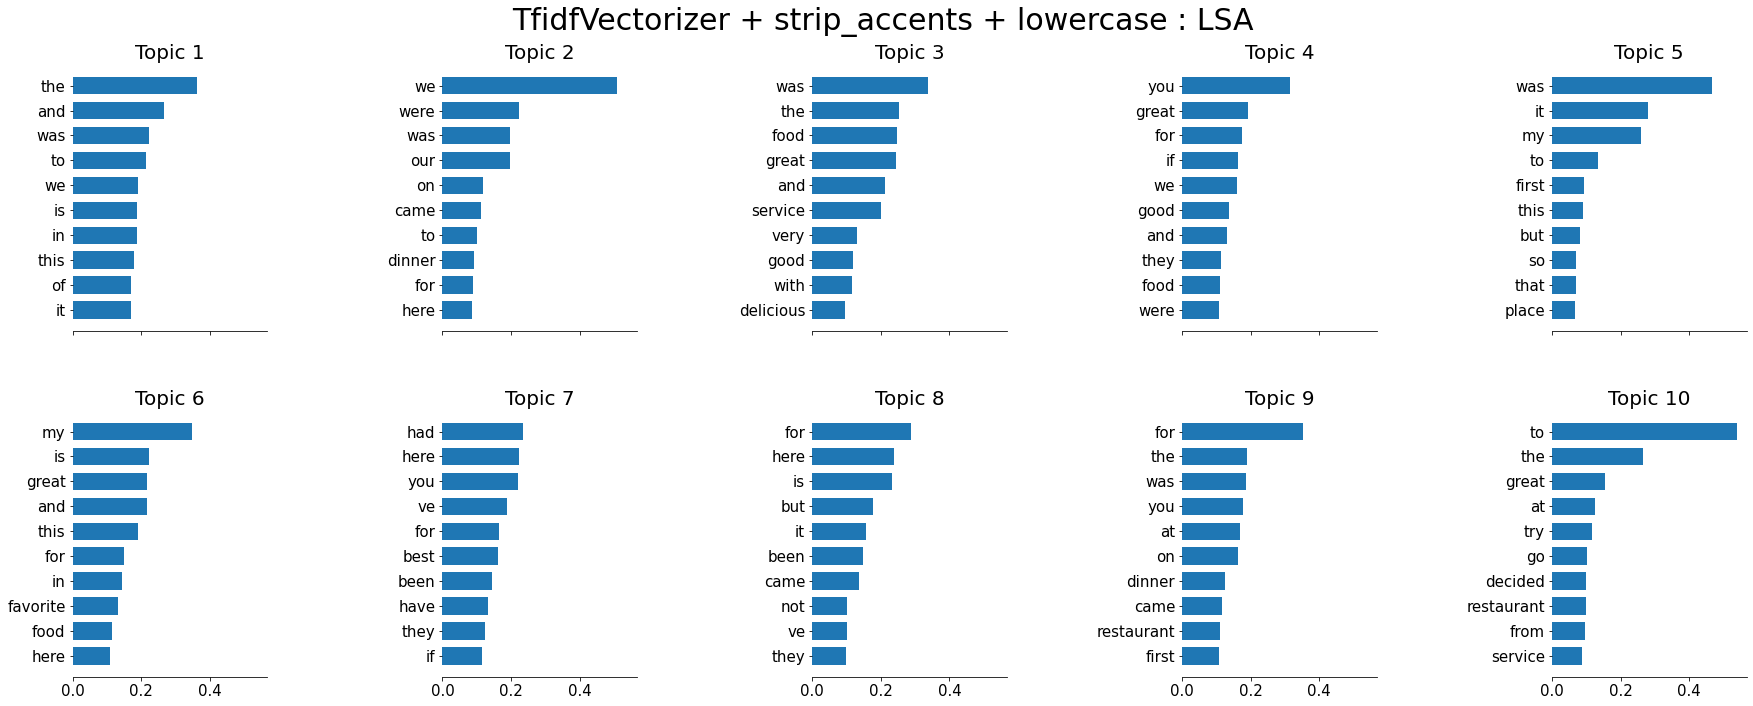

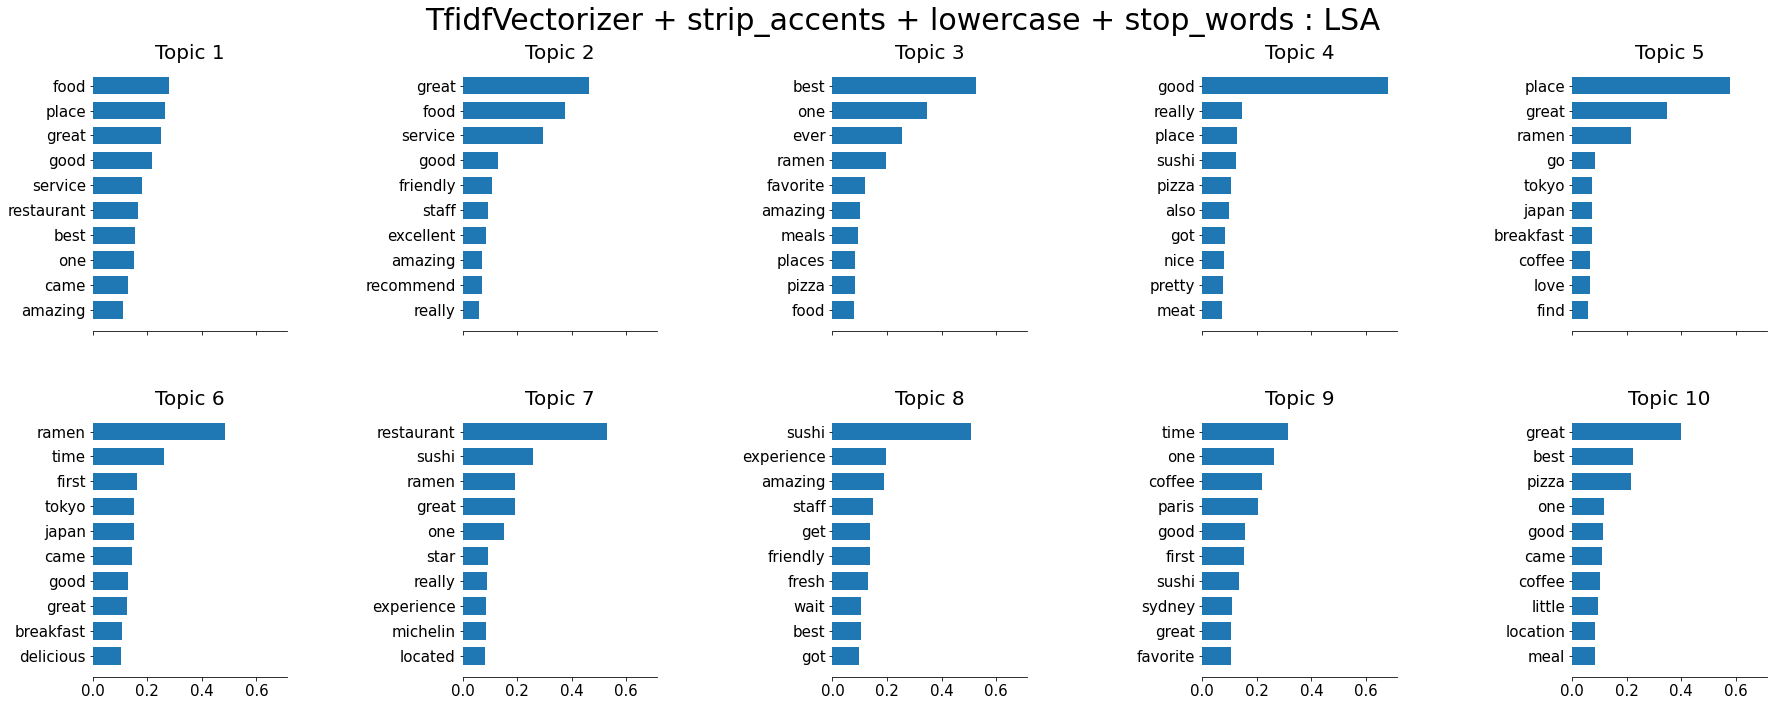

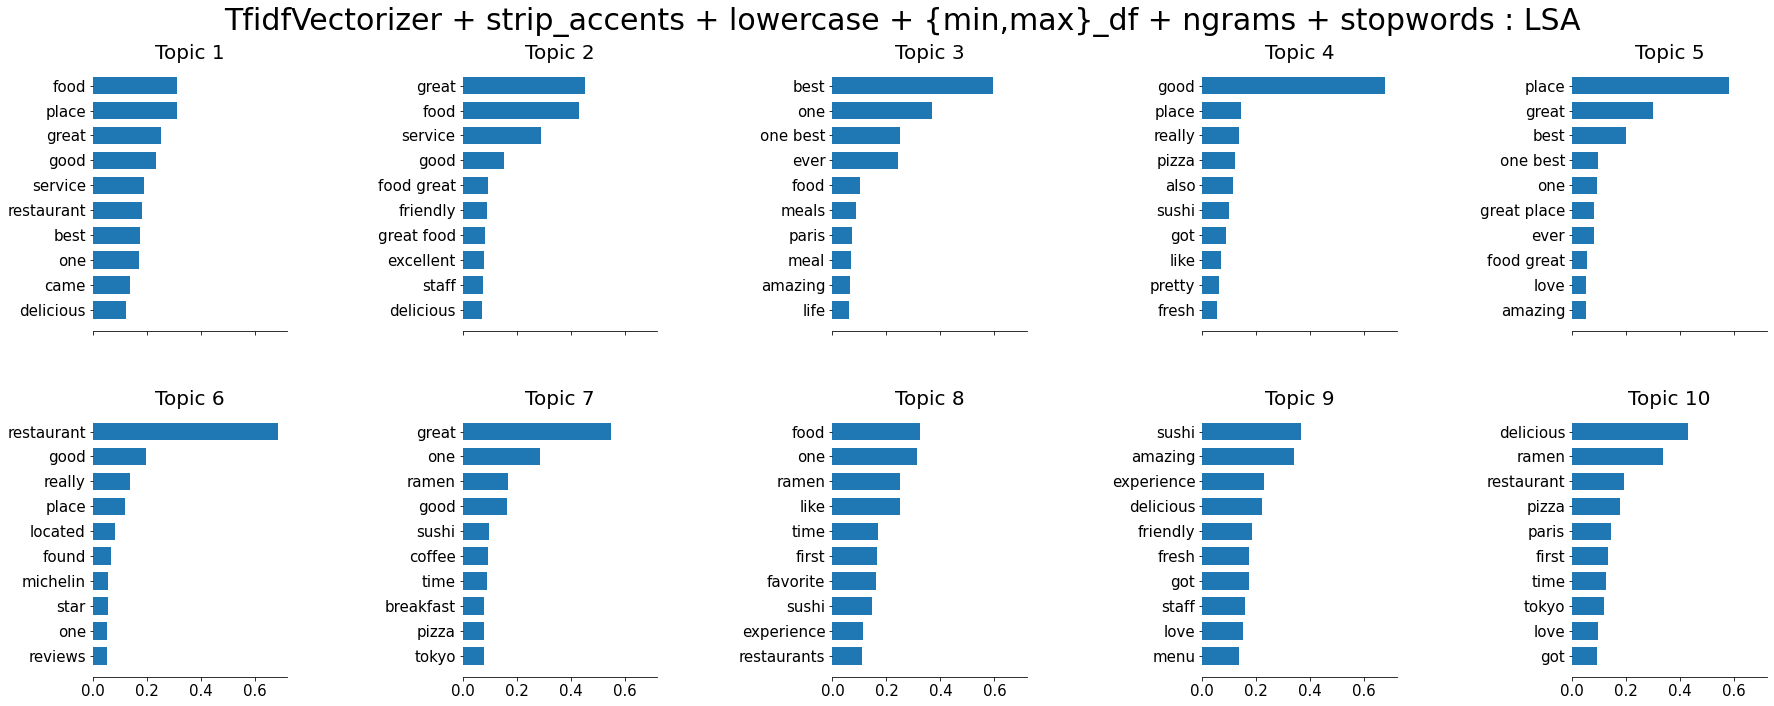

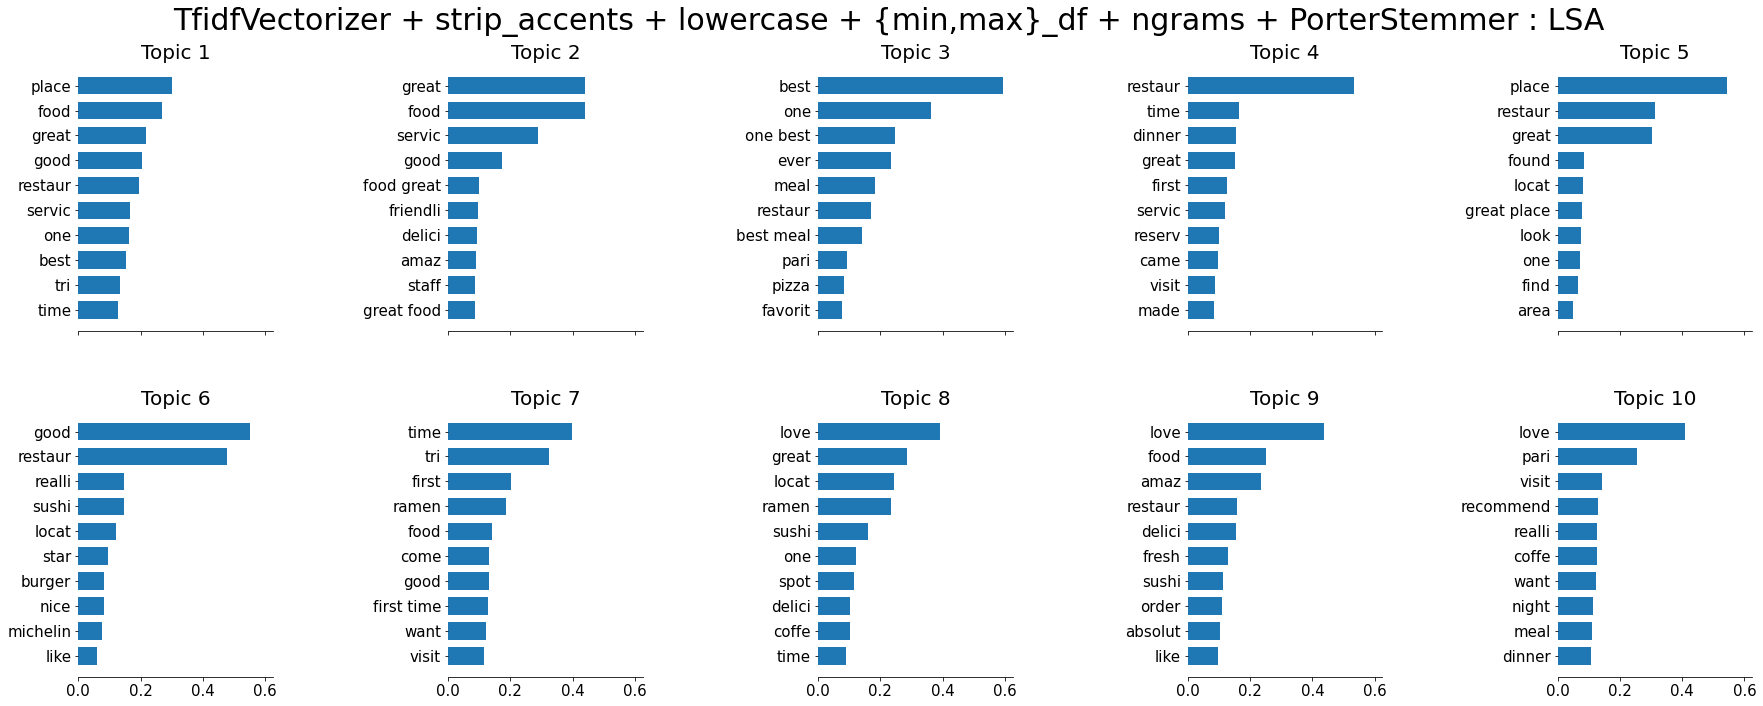

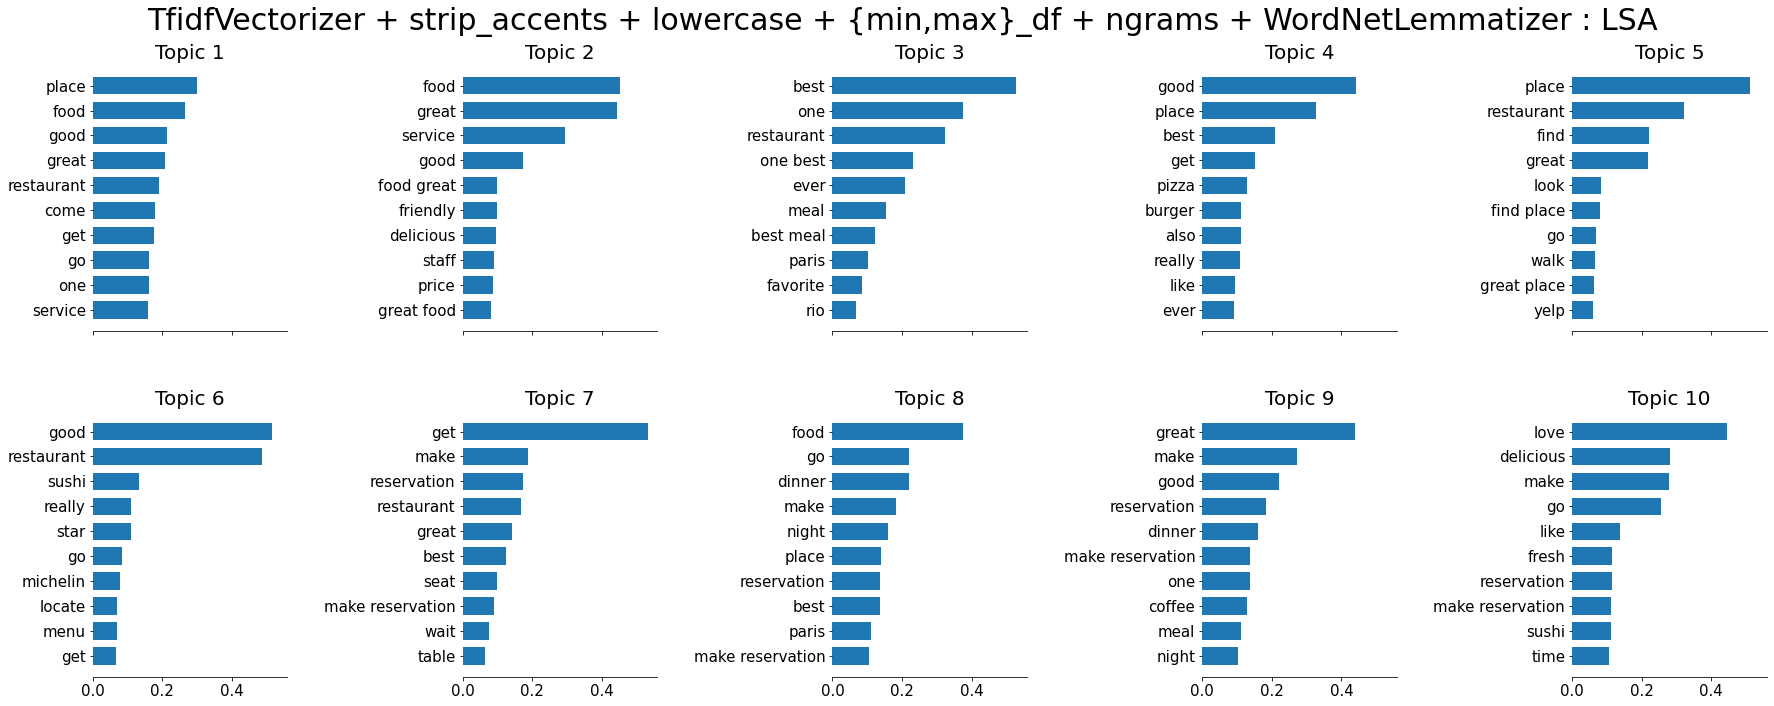

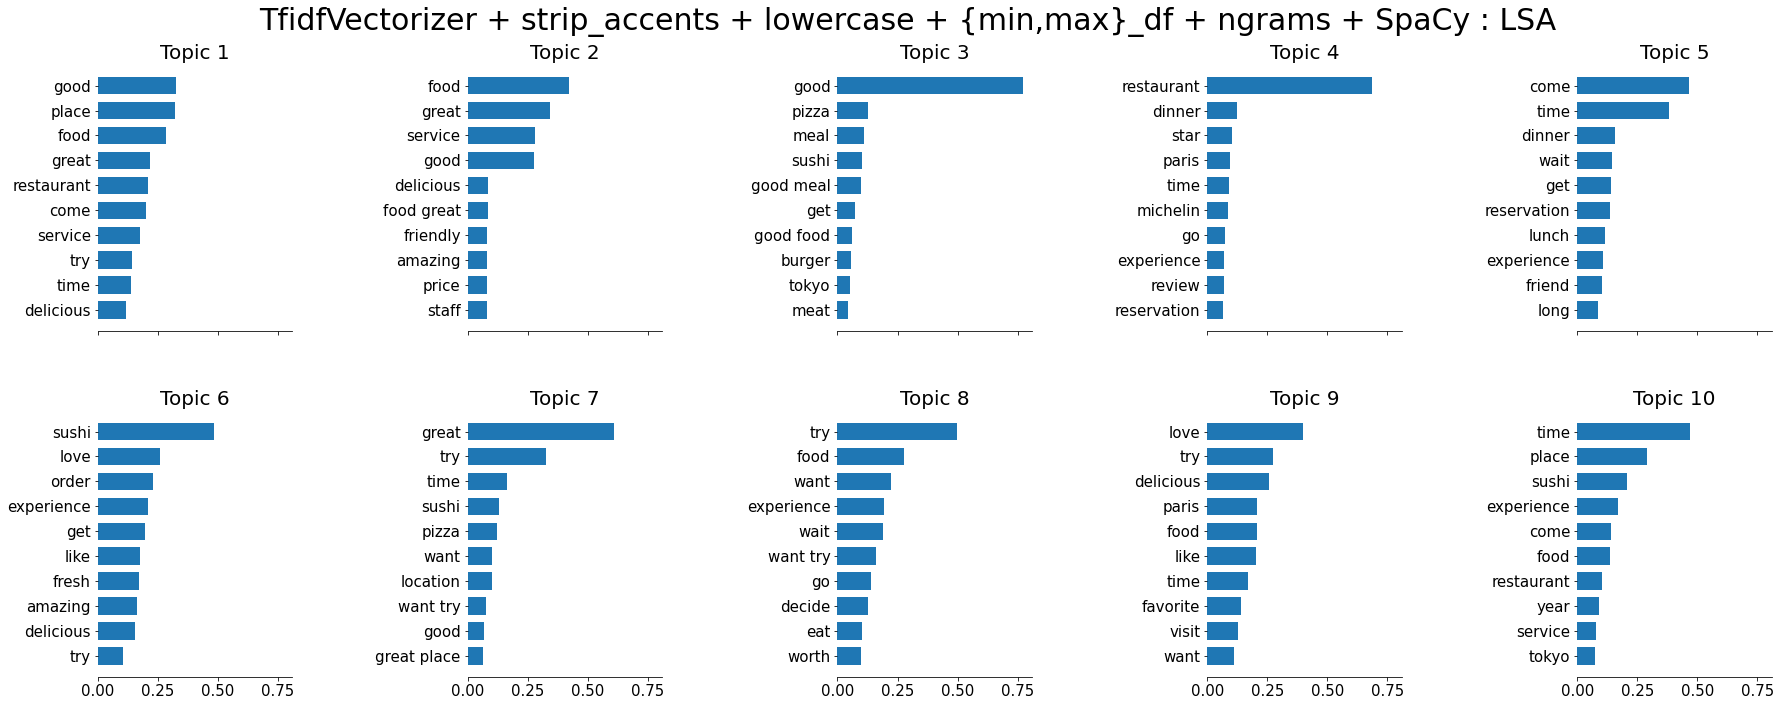

In [58]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_components = 35
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stopwords",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    words_count = pd.Series(
        X_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_lsa = lsa.fit_transform(X_vec)

    fig = px.line(
        x=range(1, n_components + 1),
        y=np.cumsum(lsa.explained_variance_ratio_),
        labels={
            "x": "Principal Component",
            "y": "Explained Variance Ratio",
        },
        title=f"{vectorizer_name} : Explained Variance Ratio",
    )
    fig.show()

    fig = px.scatter_3d(
        X_lsa,
        x=X_lsa[:, 0],
        y=X_lsa[:, 1],
        z=X_lsa[:, 2],
        labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
        title=f"{vectorizer_name} : SVD",
        color=y,
        opacity=0.5,
    )
    fig.show()

    plot_top_words(
        model=lsa,
        feature_names=vectorizer.get_feature_names(),
        n_top_words=10,
        n_topics=10,
        title=f"{vectorizer_name} : LSA",
    )


In [59]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()


vectorizer = vectorizers[
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy"
]
X_vec = vectorizer.fit_transform(X)

lda = LatentDirichletAllocation(
    n_components=n_components,
    random_state=42,
    n_jobs=-1,
).fit(X_vec)

pyLDAvis.sklearn.prepare(lda, X_vec, vectorizer)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.150666 -0.066209       1        1  4.424814
15     0.053663 -0.050151       2        1  3.696417
10    -0.016785 -0.106123       3        1  3.685850
27    -0.096357  0.008305       4        1  3.680414
5     -0.059256 -0.073181       5        1  3.626633
24     0.079602  0.128332       6        1  3.535232
20     0.167503 -0.040962       7        1  3.495181
6      0.182808 -0.004254       8        1  3.445191
7     -0.137300  0.046801       9        1  3.396582
16     0.037274 -0.101171      10        1  3.356223
28     0.002345  0.155576      11        1  3.112002
22    -0.057464  0.064564      12        1  3.058633
21    -0.130375  0.058751      13        1  3.040415
4      0.046364  0.009084      14        1  2.958810
8      0.077492  0.059771      15        1  2.879963
1      0.106473  0.025408      16        1  2.863605
18    -0.088344  0.044233      17        1  2.823081
33     0.093411 -0.138525      18        1  2.768919
13     0.053233  0.066040      19        1  2.760684
3     -0.194339  0.000281      20        1  2.741913
23     0.018316 -0.105135      21        1  2.637435
32    -0.127251 -0.030190      22        1  2.526737
17     0.009452  0.113694      23        1  2.512859
14    -0.039496  0.126685      24        1  2.446171
2     -0.034065 -0.033840      25        1  2.438638
0     -0.055789 -0.033865      26        1  2.400140
9     -0.116005  0.159139      27        1  2.360677
31     0.082702  0.051354      28        1  2.317994
25    -0.129454 -0.175502      29        1  2.297290
29     0.164936  0.101006      30        1  2.288498
26     0.093768 -0.120012      31        1  2.211350
19     0.025331  0.006995      32        1  2.146248
30     0.157594 -0.030536      33        1  2.122701
34     0.010304 -0.052613      34        1  1.994817
12    -0.029623 -0.063750      35        1  1.947881, topic_info=          Term       Freq       Total Category  logprob  loglift
154      pizza  48.000000   48.000000  Default  30.0000  30.0000
196       star  44.000000   44.000000  Default  29.0000  29.0000
124   location  39.000000   39.000000  Default  28.0000  28.0000
161     pretty  40.000000   40.000000  Default  27.0000  27.0000
228       want  49.000000   49.000000  Default  26.0000  26.0000
..         ...        ...         ...      ...      ...      ...
155      place   3.256183  160.858699  Topic35  -3.7676   0.0385
117       like   1.161398   58.706973  Topic35  -4.7986   0.0155
228       want   1.009897   49.528965  Topic35  -4.9383   0.0457
75        food   1.522987  135.640981  Topic35  -4.5275  -0.5509
45   delicious   1.009849   64.885595  Topic35  -4.9384  -0.2244

[1277 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.116087        able
0         5  0.116087        able
0        16  0.580437        able
0        27  0.116087        able
1         3  0.077789  absolutely
...     ...       ...         ...
240      18  0.067863        yelp
240      20  0.169658        yelp
240      21  0.101795        yelp
240      25  0.033932        yelp
240      29  0.135726        yelp

[1650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 16, 11, 28, 6, 25, 21, 7, 8, 17, 29, 23, 22, 5, 9, 2, 19, 34, 14, 4, 24, 33, 18, 15, 3, 1, 10, 32, 26, 30, 27, 20, 31, 35, 13])

#### Gensim LDA


In [60]:
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary


docs = X.map(tokenizers["SpaCy"])
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

results_lda = []
for num_topics in range(2, 152, 5):
    lda = LdaModel(
        corpus=corpus_tfidf,
        id2word=dictionary,
        num_topics=num_topics,
        per_word_topics=True,
        passes=10,
        random_state=42,
    )

    results = {
        "num_topics": num_topics,
        "perplexity": lda.log_perplexity(
            corpus
        ),  # Compute Perplexity (lower is better)
        "coherence": CoherenceModel(
            lda, texts=docs
        ).get_coherence(),  # Compute Coherence Score (higher is better)
    }
    results_lda.append(results)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["perplexity"],
        name="Perplexity",
        mode="lines",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["coherence"],
        name="Coherence",
        mode="lines",
    ),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="LDA Coherence and Perplexity",
    xaxis_title="Number of Topics",
    yaxis_title="Perplexity",
    yaxis2_title="Coherence",
)
fig.show()


INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(5084 unique tokens: ['area', 'early', 'fall', 'lively', 'miss']...) from 2928 documents (total 36993 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(5084 unique tokens: ['area', 'early', 'fall', 'lively', 'miss']...) from 2928 documents (total 36993 corpus positions)", 'datetime': '2021-12-06T16:49:02.849111', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 10 2021, 14:59:43) \n[GCC 11.2.0]', 'platform': 'Linux-5.13.0-22-generic-x86_64-with-glibc2.34', 'event': 'created'}
INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.utils:TfidfModel lifecycle event {'msg': 'calculated IDF weights for 2928 documents and 5084 features (35295 matrix non-zeros)', 'datetime': '2021-12-06T16:49:02.886918', 'gensim': '4.1.2', 'python': '3.9.7 (de

In [61]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

lda = LdaModel(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=80,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)


INFO:gensim.models.ldamodel:using symmetric alpha at 0.0125
INFO:gensim.models.ldamodel:using symmetric eta at 0.0125
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 80 topics, 10 passes over the supplied corpus of 2928 documents, updating model once every 2000 documents, evaluating perplexity every 2928 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/2928
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 2928 documents
INFO:gensim.models.ldamodel:topic #77 (0.013): 0.000*"misojyu" + 0.000*"pen" + 0.000*"supermarket" + 0.000*"sawtelle" + 0.000*"unexpectedly" + 0.000*"takoyaki" + 0.000*"tonki" + 0.000*"meguro" + 0.000*"nakajima" + 0.000*"ball"
INFO:gensim.models.ldamodel:topic #2 (0.013): 0.000*"misojyu" + 0.000*"pen" + 0.000*"supermarket" + 0.000*"sawtelle" + 0.000*"unexpectedly" + 0.000*"

PreparedData(topic_coordinates=         x    y  topics  cluster  Freq
topic                                 
0      0.0  0.0       1        1  1.25
1      0.0  0.0       2        1  1.25
58     0.0  0.0       3        1  1.25
57     0.0  0.0       4        1  1.25
56     0.0  0.0       5        1  1.25
...    ...  ...     ...      ...   ...
25     0.0  0.0      76        1  1.25
24     0.0  0.0      77        1  1.25
23     0.0  0.0      78        1  1.25
22     0.0  0.0      79        1  1.25
79     0.0  0.0      80        1  1.25

[80 rows x 5 columns], topic_info=              Term      Freq     Total Category  logprob  loglift
0             area  7.000000  7.000000  Default  30.0000     30.0
3387          ball  7.000000  7.000000  Default  29.0000     29.0
3394   supermarket  7.000000  7.000000  Default  28.0000     28.0
3393      sawtelle  7.000000  7.000000  Default  27.0000     27.0
3392  unexpectedly  7.000000  7.000000  Default  26.0000     26.0
...            ...       ...       ...      ...      ...      ...
25          decide  0.090954  7.276355  Topic80  -8.5339     -0.0
26          friend  0.090954  7.276355  Topic80  -8.5339     -0.0
27            item  0.090954  7.276355  Topic80  -8.5339     -0.0
28            menu  0.090954  7.276355  Topic80  -8.5339     -0.0
29           paris  0.090954  7.276355  Topic80  -8.5339     -0.0

[2430 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 60, 61, 62, 72, 79, 78, 77, 76, 75, 74, 73, 71, 63, 70, 69, 68, 67, 66, 65, 64, 42, 41, 40, 11, 18, 17, 16, 15, 14, 13, 12, 10, 20, 9, 8, 7, 6, 5, 4, 3, 19, 21, 39, 31, 38, 37, 36, 35, 34, 33, 32, 30, 22, 29, 28, 27, 26, 25, 24, 23, 80])

In [62]:
corpus_tfidf[26]

[(9, 0.22353818982582632),
 (17, 0.09585773913197125),
 (29, 0.17722348127126875),
 (49, 0.17543189893136552),
 (54, 0.29780447158338536),
 (55, 0.17614238323075815),
 (59, 0.15744545606652563),
 (170, 0.17614238323075815),
 (226, 0.49905485058540117),
 (227, 0.22508202000528524),
 (228, 0.34369365237113303),
 (229, 0.2785799299333104),
 (230, 0.4557179403156242)]

In [63]:
corpus_lda = lda[corpus]



In [64]:
# both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
for doc, as_text in zip(corpus_lda, X):
    print(doc, as_text)
    break

([(0, 0.0125), (1, 0.0125), (2, 0.0125), (3, 0.0125), (4, 0.0125), (5, 0.0125), (6, 0.0125), (7, 0.0125), (8, 0.0125), (9, 0.0125), (10, 0.0125), (11, 0.0125), (12, 0.0125), (13, 0.0125), (14, 0.0125), (15, 0.0125), (16, 0.0125), (17, 0.0125), (18, 0.0125), (19, 0.0125), (20, 0.0125), (21, 0.0125), (22, 0.0125), (23, 0.0125), (24, 0.0125), (25, 0.0125), (26, 0.0125), (27, 0.0125), (28, 0.0125), (29, 0.0125), (30, 0.0125), (31, 0.0125), (32, 0.0125), (33, 0.0125), (34, 0.0125), (35, 0.0125), (36, 0.0125), (37, 0.0125), (38, 0.0125), (39, 0.0125), (40, 0.0125), (41, 0.0125), (42, 0.0125), (43, 0.0125), (44, 0.0125), (45, 0.0125), (46, 0.0125), (47, 0.0125), (48, 0.0125), (49, 0.0125), (50, 0.0125), (51, 0.0125), (52, 0.0125), (53, 0.0125), (54, 0.0125), (55, 0.0125), (56, 0.0125), (57, 0.0125), (58, 0.0125), (59, 0.0125), (60, 0.0125), (61, 0.0125), (62, 0.0125), (63, 0.0125), (64, 0.0125), (65, 0.0125), (66, 0.0125), (67, 0.0125), (68, 0.0125), (69, 0.0125), (70, 0.0125), (71, 0.0125), 

In [65]:
ratings_diff = reviews_df.join(
    businesses_df.set_index("business_alias")[["business_rating"]],
    on="business_alias",
)
reviews_df["rating_diff"] = (
    ratings_diff["review_rating"] - ratings_diff["business_rating"]
)
reviews_df["rating_sentiment"] = (reviews_df["rating_diff"] > 0).astype(int)


reviews_df[["rating_diff", "rating_sentiment"]].describe()


rating_diff  rating_sentiment
count  2928.000000       2928.000000
mean      0.125683          0.572404
std       0.875052          0.494814
min      -3.500000          0.000000
25%      -0.500000          0.000000
50%       0.500000          1.000000
75%       0.500000          1.000000
max       2.000000          1.000000

In [66]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

lda = LdaModel(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=n_components,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)


INFO:gensim.models.ldamodel:using symmetric alpha at 0.02857142857142857
INFO:gensim.models.ldamodel:using symmetric eta at 0.02857142857142857
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 35 topics, 10 passes over the supplied corpus of 2928 documents, updating model once every 2000 documents, evaluating perplexity every 2928 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/2928
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 2928 documents
INFO:gensim.models.ldamodel:topic #5 (0.029): 0.006*"come" + 0.006*"try" + 0.005*"place" + 0.005*"know" + 0.005*"friend" + 0.004*"wait" + 0.004*"tell" + 0.004*"paris" + 0.004*"thursday" + 0.004*"buffet"
INFO:gensim.models.ldamodel:topic #9 (0.029): 0.006*"visit" + 0.005*"reservation" + 0.005*"restaurant" + 0.005*"choose" + 0.005*"good" + 0.005*"com

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.141358  0.056176       1        1  7.358884
31     0.131470  0.011917       2        1  6.398422
26     0.106977 -0.019671       3        1  5.672937
21     0.077632  0.154853       4        1  4.833811
30     0.067275 -0.056190       5        1  4.444204
1      0.083528 -0.083942       6        1  4.434548
8      0.090903 -0.026554       7        1  4.324805
13     0.082846 -0.032231       8        1  4.110452
7      0.071057  0.018258       9        1  4.010904
22     0.060817 -0.025059      10        1  3.838393
0      0.075469 -0.023078      11        1  3.603049
19     0.029989  0.014600      12        1  3.473949
25     0.021370  0.064401      13        1  3.472553
3      0.048629 -0.004839      14        1  3.472286
23     0.039515  0.027464      15        1  3.337990
12     0.041520  0.043362      16        1  3.248947
18     0.000914  0.098464      17        1  2.596893
32    -0.026010 -0.040957      18        1  2.483156
11     0.004262 -0.106537      19        1  2.334809
34     0.003872 -0.081389      20        1  2.242690
6     -0.024768 -0.069529      21        1  2.052608
10    -0.048870 -0.041719      22        1  1.725653
14    -0.043623 -0.022584      23        1  1.610050
2     -0.027385  0.031120      24        1  1.599373
4     -0.079216  0.003503      25        1  1.597733
27    -0.035336  0.010260      26        1  1.543283
33    -0.069470  0.026628      27        1  1.458754
16    -0.102869  0.016351      28        1  1.371989
17    -0.113803  0.006481      29        1  1.287045
29    -0.115139  0.004036      30        1  1.123815
28    -0.098872 -0.002207      31        1  1.115993
9     -0.090389  0.018044      32        1  1.067821
20    -0.080913 -0.000985      33        1  1.020452
24    -0.106090  0.005939      34        1  0.936691
5     -0.116651  0.025616      35        1  0.795059, topic_info=           Term       Freq      Total Category  logprob  loglift
572        view  63.000000  63.000000  Default  30.0000  30.0000
594      coffee  79.000000  79.000000  Default  29.0000  29.0000
1290      raman  60.000000  60.000000  Default  28.0000  28.0000
619        tell  29.000000  29.000000  Default  27.0000  27.0000
179       local  38.000000  38.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2609    manager   1.181710  13.417268  Topic35  -5.5170   2.4049
739   expensive   0.977735  17.064844  Topic35  -5.7065   1.9750
412      salmon   1.111175  25.747759  Topic35  -5.5786   1.6916
248   breakfast   1.498402  76.976490  Topic35  -5.2796   0.8954
183        walk   1.187137  72.449437  Topic35  -5.5124   0.7232

[1664 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
642       4  0.648318   ability
286       3  0.318923      able
286       4  0.550867      able
286      12  0.057986      able
549      12  0.149431  absolute
...     ...       ...       ...
224       9  0.862852       yum
224      26  0.033187       yum
225       5  0.216199     yummy
225      33  0.648598     yummy
3459     19  0.666334      zero

[3954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 32, 27, 22, 31, 2, 9, 14, 8, 23, 1, 20, 26, 4, 24, 13, 19, 33, 12, 35, 7, 11, 15, 3, 5, 28, 34, 17, 18, 30, 29, 10, 21, 25, 6])

In [67]:
from gensim.models import HdpModel


hdp = HdpModel(
    corpus=corpus,
    id2word=dictionary,
    # T=n_components, # Maximum number of topics
    random_state=42,
)

pyLDAvis.gensim_models.prepare(hdp, corpus, dictionary)


INFO:gensim.models.hdpmodel:(0, '0.002*julius + 0.002*minute + 0.002*namesake + 0.001*rush + 0.001*find + 0.001*sweat + 0.001*theory + 0.001*minis + 0.001*caviar + 0.001*med')
INFO:gensim.models.hdpmodel:(1, '0.002*hottie + 0.002*revolving + 0.002*hot + 0.001*musical + 0.001*buttery + 0.001*utage + 0.001*contrast + 0.001*kaya + 0.001*bulgogi + 0.001*fix')
INFO:gensim.models.hdpmodel:(2, '0.002*good + 0.002*food + 0.002*menu + 0.001*follow + 0.001*great + 0.001*get + 0.001*manten + 0.001*grab + 0.001*foie + 0.001*tasting')
INFO:gensim.models.hdpmodel:(3, '0.002*restaurant + 0.002*visit + 0.001*village + 0.001*destinations + 0.001*casual + 0.001*pita + 0.001*sichuan + 0.001*go + 0.001*daniel + 0.001*honor')
INFO:gensim.models.hdpmodel:(4, '0.002*motomura + 0.002*ab + 0.002*ground + 0.002*right + 0.002*come + 0.002*shellfish + 0.001*place + 0.001*hurricane + 0.001*great + 0.001*combo')
INFO:gensim.models.hdpmodel:(5, '0.002*tijuca + 0.002*regret + 0.002*proprietor + 0.001*saucy + 0.001*ga

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.001359  0.016444       1        1  4.942430
13     0.005773  0.013957       2        1  3.666999
55     0.014283  0.002479       3        1  3.170918
2      0.016825 -0.004298       4        1  2.770190
3      0.010997 -0.003438       5        1  2.679173
...         ...       ...     ...      ...       ...
135   -0.001113  0.014617     146        1  0.082584
137   -0.000290  0.014658     147        1  0.076497
147   -0.006929 -0.008509     148        1  0.074345
126   -0.000485 -0.003231     149        1  0.049611
138    0.013809  0.014231     150        1  0.031544

[150 rows x 5 columns], topic_info=             Term       Freq      Total  Category  logprob  loglift
21          place  32.000000  32.000000   Default  30.0000  30.0000
111         great  26.000000  26.000000   Default  29.0000  29.0000
482   exceptional   9.000000   9.000000   Default  28.0000  28.0000
15           food  33.000000  33.000000   Default  27.0000  27.0000
930         musée   9.000000   9.000000   Default  26.0000  26.0000
...           ...        ...        ...       ...      ...      ...
4462       peking   0.012995   8.245272  Topic150  -6.8002   1.6087
3407        curve   0.013870   9.101907  Topic150  -6.7350   1.5750
1333      hostess   0.012908   8.510234  Topic150  -6.8068   1.5704
1616       awhile   0.011795   7.670120  Topic150  -6.8970   1.5842
2243          pho   0.012394   8.921810  Topic150  -6.8475   1.4825

[5879 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2186      6  0.256028          ab
5042      1  0.129483     abalone
5042      3  0.129483     abalone
4446     10  0.149925    absinthe
556       3  0.103037  absolutely
...     ...       ...         ...
1545      1  0.230659        yuzu
1545      2  0.115330        yuzu
3459      7  0.144136        zero
1496      3  0.130678      zombie
3969      4  0.161972        zona

[3666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 14, 56, 3, 4, 5, 103, 57, 39, 1, 8, 70, 101, 21, 10, 47, 77, 52, 32, 2, 51, 30, 115, 13, 43, 69, 78, 132, 27, 105, 41, 16, 25, 40, 6, 85, 73, 44, 65, 63, 82, 71, 99, 75, 24, 35, 58, 33, 59, 36, 55, 124, 86, 9, 76, 29, 22, 81, 38, 7, 74, 11, 42, 72, 87, 54, 26, 79, 31, 60, 92, 64, 102, 128, 19, 93, 111, 12, 142, 68, 141, 48, 53, 61, 88, 45, 129, 108, 116, 20, 104, 37, 133, 46, 89, 110, 34, 143, 144, 98, 137, 117, 23, 15, 83, 91, 17, 84, 109, 120, 107, 49, 66, 149, 97, 67, 62, 95, 147, 112, 90, 135, 18, 113, 123, 118, 106, 80, 96, 145, 100, 126, 125, 140, 146, 134, 130, 150, 94, 50, 122, 119, 121, 114, 131, 136, 138, 148, 127, 139])

### Word Embedding


In [68]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5084 word types from a corpus of 36993 raw words and 2928 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1170 unique words (23.01337529504327%% of original 5084, drops 3914)', 'datetime': '2021-12-06T16:55:16.823810', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 10 2021, 14:59:43) \n[GCC 11.2.0]', 'platform': 'Linux-5.13.0-22-generic-x86_64-with-glibc2.34', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 30867 word corpus (83.44011029113616%% of original 36993, drops 6126)', 'datetime': '2021-12-06T16:55:16.824681', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 10 2021, 14:59:43) \n[GCC 11.2.0]', 'platform': 'Linux-5.13.0-22-

[('decide', 0.9993124008178711),
 ('french', 0.9993094801902771),
 ('experience', 0.9992795586585999),
 ('spot', 0.9992650747299194),
 ('cook', 0.9992634654045105),
 ('start', 0.9992560744285583),
 ('excellent', 0.9992555379867554),
 ('nyc', 0.9992534518241882),
 ('dinner', 0.9992446303367615),
 ('place', 0.9992387890815735),
 ('restaurant', 0.9992343187332153),
 ('locate', 0.9992322325706482),
 ('try', 0.999230146408081),
 ('day', 0.9992287755012512),
 ('food', 0.9992246031761169),
 ('table', 0.9992241263389587),
 ('paris', 0.999224066734314),
 ('get', 0.9992222785949707),
 ('service', 0.9992198944091797),
 ('like', 0.9992141127586365)]

In [69]:
from sklearn.manifold import TSNE


X_w2v = [word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=word2vec.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="Word2Vec TSNE",
)
fig.show()


### Fasttext


In [70]:
from gensim.models.fasttext import FastText


fasttext = FastText(docs)
fasttext.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5084 word types from a corpus of 36993 raw words and 2928 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=5 retains 1170 unique words (23.01337529504327%% of original 5084, drops 3914)', 'datetime': '2021-12-06T16:55:20.932405', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 10 2021, 14:59:43) \n[GCC 11.2.0]', 'platform': 'Linux-5.13.0-22-generic-x86_64-with-glibc2.34', 'event': 'prepare_vocab'}
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=5 leaves 30867 word corpus (83.44011029113616%% of original 36993, drops 6126)', 'datetime': '2021-12-06T16:55:20.933093', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 10 2021, 14:59:43) \n[GCC 11.2.0]', 'platform': 'Linux-5.13.0-22-

[('super', 0.9999331831932068),
 ('butter', 0.9999313354492188),
 ('affordable', 0.9999290108680725),
 ('knowledgeable', 0.9999288320541382),
 ('diner', 0.99992835521698),
 ('later', 0.9999282360076904),
 ('cheese', 0.9999281167984009),
 ('choice', 0.999927818775177),
 ('lobster', 0.9999275803565979),
 ('expectation', 0.9999273419380188),
 ('flavorful', 0.9999273419380188),
 ('question', 0.9999268651008606),
 ('fantastic', 0.9999266266822815),
 ('break', 0.9999262094497681),
 ('charming', 0.9999262094497681),
 ('reasonable', 0.9999259114265442),
 ('tasting', 0.9999257326126099),
 ('basically', 0.9999255537986755),
 ('temple', 0.9999254941940308),
 ('counter', 0.9999252557754517)]

In [71]:
from sklearn.manifold import TSNE


X_w2v = [fasttext.wv[x] for x in fasttext.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=fasttext.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="FastText TSNE",
)
fig.show()


## Photos


In [72]:
img_path = os.path.join(data_path, "photos", photos_df["file_name"].values[0])


NameError: name 'data_path' is not defined

In [ ]:
from PIL import Image

# Charger l'image
img = Image.open(img_path)

# Afficher l'image chargée
img.show()

# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20, 100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)
print(mat)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))


Largeur : 1000 px, hauteur : 666 px
Format des pixels : RGB
Valeur du pixel situé en (20,100) : (218, 109, 68)
[[[ 42  15   4]
  [ 43  16   5]
  [ 44  17   6]
  ...
  [ 23   9  26]
  [ 24   7  25]
  [ 27   8  27]]

 [[ 44  18   5]
  [ 46  18   6]
  [ 47  19   7]
  ...
  [ 26   9  28]
  [ 27   8  28]
  [ 29  10  29]]

 [[ 47  17   6]
  [ 48  18   7]
  [ 50  20   9]
  ...
  [ 30   8  31]
  [ 31   9  32]
  [ 35  11  33]]

 ...

 [[214 116  87]
  [211 113  86]
  [202 107  79]
  ...
  [202 171 187]
  [199 166 183]
  [195 161 178]]

 [[195  96  65]
  [190  91  62]
  [201 102  73]
  ...
  [199 166 183]
  [194 160 177]
  [192 155 173]]

 [[201  97  68]
  [192  91  63]
  [201 100  72]
  ...
  [196 162 178]
  [192 155 172]
  [188 149 168]]]
Taille de la matrice de pixels : (666, 1000, 3)


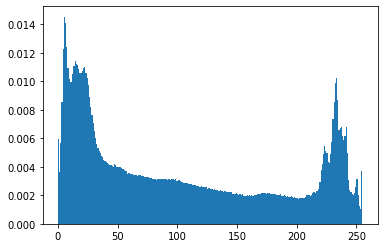

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger l'image comme matrice de pixels
img = np.array(Image.open(img_path))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256), density=True)
plt.show()


In [ ]:
# Charger l'image sous forme d'une matrice de pixels
img = Image.open(img_path)


from PIL import ImageFilter

# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
img.filter(ImageFilter.BoxBlur(10)).show()


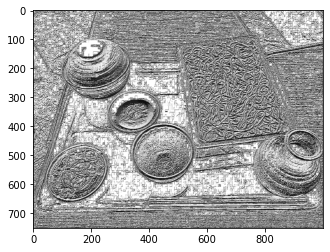

In [ ]:
import cv2 as cv

from skimage.feature import local_binary_pattern


photo = photos_df.sample().iloc[0]
img_path = os.path.join(data_path, "photos", photo["file_name"])
img = cv.imread(img_path, 0)


# Compute the Local Binary Pattern representation
lbp = local_binary_pattern(img, P=8, R=1)


# Display the image
plt.imshow(lbp, cmap="gray")
plt.show()


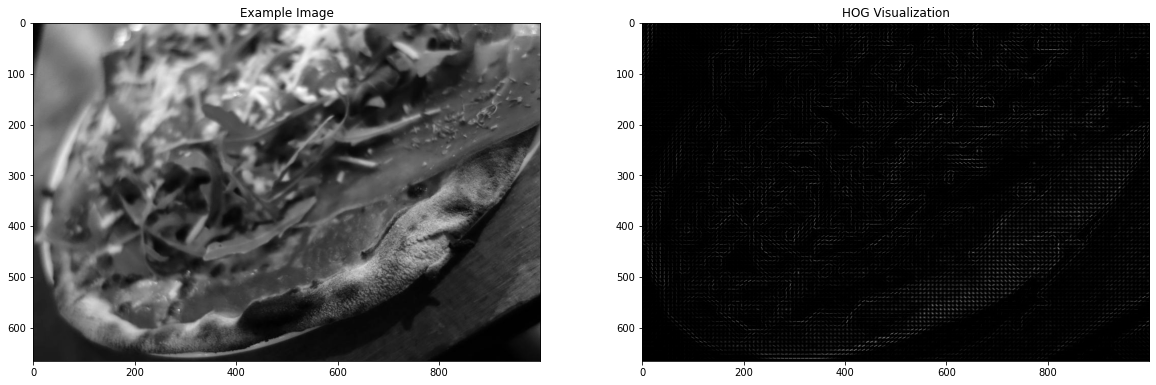

In [ ]:
from skimage.feature import hog
import cv2 as cv


photo = photos_df.sample().iloc[0]
img_path = os.path.join(data_path, "photos", photo["file_name"])
img = cv.imread(img_path, 0)


# Call our function with vis=True to see an image output
features, hog_image = hog(
    img,
    transform_sqrt=True,
    visualize=True,
)

# Plot the examples
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Example Image")
plt.subplot(122)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Visualization")
plt.show()


In [ ]:
import cv2 as cv


photos_features_df = pd.DataFrame(
    columns=["file_name", "orb_keypoints", "orb_descriptors"]
)
for photo in photos_df.itertuples():
    img_path = os.path.join(data_path, "photos", photo.file_name)
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    # ORB Features
    orb = cv.ORB_create()
    orb_keypoints = orb.detect(img, None)
    orb_keypoints, orb_descriptors = orb.compute(img, orb_keypoints)

    photos_features_df = photos_features_df.append(
        {
            "file_name": photo.file_name,
            "orb_keypoints": orb_keypoints,
            "orb_descriptors": orb_descriptors,
        },
        ignore_index=True,
    )

photos_features_df


file_name  \
0    le-comptoir-de-la-gastronomie-paris_0200c0c54c...   
1    l-as-du-fallafel-paris_ab3344d5839c2238e825b28...   
2    angelina-paris_0aced3805db4ea7246d49c771fc48d8...   
3    l-avant-comptoir-paris-3_73670e8469e59d89b41bf...   
4    la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb...   
..                                                 ...   
994  mca-cafe-the-rocks-2_7d3f47187838d8be21cc30db2...   
995  pizza-autentico-surry-hills_8890d05a023a2a255d...   
996  malabar-indian-restaurant-darlinghurst-2_38463...   
997  harajuku-gyoza-beer-stadium-darling-harbour-da...   
998  harts-pub-the-rocks-2_af6c192e2e07a42c2bbabb40...   

                                         orb_keypoints  \
0    (<KeyPoint 0x7f96f60ba660>, <KeyPoint 0x7f96f6...   
1    (<KeyPoint 0x7f96f60c45d0>, <KeyPoint 0x7f96f6...   
2    (<KeyPoint 0x7f96f60c3540>, <KeyPoint 0x7f96f6...   
3    (<KeyPoint 0x7f96f60c24b0>, <KeyPoint 0x7f96f6...   
4    (<KeyPoint 0x7f96f60c1420>, <KeyPoint 0x7f96f6...   
..                                                 ...   
994  (<KeyPoint 0x7f96e15663c0>, <KeyPoint 0x7f96e1...   
995  (<KeyPoint 0x7f96e18e3930>, <KeyPoint 0x7f96e1...   
996  (<KeyPoint 0x7f96e15705a0>, <KeyPoint 0x7f96e1...   
997  (<KeyPoint 0x7f96e156f510>, <KeyPoint 0x7f96e1...   
998  (<KeyPoint 0x7f96e157c480>, <KeyPoint 0x7f96e1...   

                                       orb_descriptors  
0    [[213, 109, 201, 5, 146, 74, 175, 136, 114, 23...  
1    [[2, 4, 50, 219, 115, 160, 185, 67, 156, 5, 95...  
2    [[46, 50, 240, 145, 238, 241, 248, 210, 59, 11...  
3    [[121, 65, 110, 101, 7, 26, 89, 56, 97, 32, 24...  
4    [[13, 51, 123, 65, 114, 159, 248, 88, 105, 232...  
..                                                 ...  
994  [[134, 123, 45, 163, 168, 15, 159, 216, 138, 2...  
995  [[11, 159, 98, 153, 119, 209, 186, 103, 29, 77...  
996  [[24, 184, 188, 241, 53, 175, 49, 150, 255, 59...  
997  [[89, 159, 87, 101, 194, 91, 110, 177, 33, 96,...  
998  [[129, 106, 159, 153, 108, 137, 168, 198, 238,...  

[999 rows x 3 columns]

In [ ]:
orb_features = [
    desc
    for photo_orb in photos_features_df["orb_descriptors"]
    for desc in photo_orb
]
orb_features


[array([213, 109, 201,   5, 146,  74, 175, 136, 114, 230, 138, 143, 209,
        102, 219,  18,  51, 236,  72, 254, 100, 212, 253, 106, 252,   4,
        143,  36, 173, 243,   7,  84], dtype=uint8),
 array([ 88, 176, 184, 250, 152, 237,  81, 223, 178,  29, 172,  25,  55,
        247,  74,  18, 133, 155, 237,  16,  26,  75, 250,  51, 219, 197,
         53, 125, 176,   0, 167, 107], dtype=uint8),
 array([216, 207,  86, 167, 242,  10, 126, 181,  57, 130, 106, 245,  79,
         35, 128, 209,  54, 253, 229, 238, 224, 212, 141, 110, 166, 227,
        103, 128,  46, 182, 171,   8], dtype=uint8),
 array([232, 252,  55,  94,  73, 221,  84, 165, 235,  21,  36,  24, 174,
        209,  76, 183, 129,  50, 200,  64,  98, 109, 186,  55,  35, 217,
         16,  59,  66,  16, 206,  46], dtype=uint8),
 array([172,  12, 150, 126, 137, 233,  20,  35, 190,  23, 231,  17, 230,
        241,  33, 155, 201, 114, 234,   2,  48, 237,  90,  63, 195, 243,
         80,  27, 210, 113, 238, 138], dtype=uint8),
 arra

In [ ]:
from sklearn.preprocessing import StandardScaler


orb_scaler = StandardScaler().fit(orb_features)
orb_features_std = orb_scaler.transform(orb_features)


In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=8, base=2, num=10, dtype=int):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        orb_features_std
    )
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(
    scores, x="n_clusters", y="inertia", title="Average clusters inertia"
)
fig.show()


In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans


orb_features = 50
orb_kmeans = MiniBatchKMeans(n_clusters=orb_features, random_state=42).fit(
    orb_features_std
)

photos_features_df["orb_clusters"] = [
    orb_kmeans.predict(orb_scaler.transform(desc))
    for desc in photos_features_df["orb_descriptors"]
]

for cluster in range(orb_features):
    photos_features_df[f"orb_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"orb_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "orb_clusters"]
        ).count(cluster)

photos_features_df


file_name  \
0    le-comptoir-de-la-gastronomie-paris_0200c0c54c...   
1    l-as-du-fallafel-paris_ab3344d5839c2238e825b28...   
2    angelina-paris_0aced3805db4ea7246d49c771fc48d8...   
3    l-avant-comptoir-paris-3_73670e8469e59d89b41bf...   
4    la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb...   
..                                                 ...   
994  mca-cafe-the-rocks-2_7d3f47187838d8be21cc30db2...   
995  pizza-autentico-surry-hills_8890d05a023a2a255d...   
996  malabar-indian-restaurant-darlinghurst-2_38463...   
997  harajuku-gyoza-beer-stadium-darling-harbour-da...   
998  harts-pub-the-rocks-2_af6c192e2e07a42c2bbabb40...   

                                         orb_keypoints  \
0    (<KeyPoint 0x7f96f60ba660>, <KeyPoint 0x7f96f6...   
1    (<KeyPoint 0x7f96f60c45d0>, <KeyPoint 0x7f96f6...   
2    (<KeyPoint 0x7f96f60c3540>, <KeyPoint 0x7f96f6...   
3    (<KeyPoint 0x7f96f60c24b0>, <KeyPoint 0x7f96f6...   
4    (<KeyPoint 0x7f96f60c1420>, <KeyPoint 0x7f96f6...   
..                                                 ...   
994  (<KeyPoint 0x7f96e15663c0>, <KeyPoint 0x7f96e1...   
995  (<KeyPoint 0x7f96e18e3930>, <KeyPoint 0x7f96e1...   
996  (<KeyPoint 0x7f96e15705a0>, <KeyPoint 0x7f96e1...   
997  (<KeyPoint 0x7f96e156f510>, <KeyPoint 0x7f96e1...   
998  (<KeyPoint 0x7f96e157c480>, <KeyPoint 0x7f96e1...   

                                       orb_descriptors  \
0    [[213, 109, 201, 5, 146, 74, 175, 136, 114, 23...   
1    [[2, 4, 50, 219, 115, 160, 185, 67, 156, 5, 95...   
2    [[46, 50, 240, 145, 238, 241, 248, 210, 59, 11...   
3    [[121, 65, 110, 101, 7, 26, 89, 56, 97, 32, 24...   
4    [[13, 51, 123, 65, 114, 159, 248, 88, 105, 232...   
..                                                 ...   
994  [[134, 123, 45, 163, 168, 15, 159, 216, 138, 2...   
995  [[11, 159, 98, 153, 119, 209, 186, 103, 29, 77...   
996  [[24, 184, 188, 241, 53, 175, 49, 150, 255, 59...   
997  [[89, 159, 87, 101, 194, 91, 110, 177, 33, 96,...   
998  [[129, 106, 159, 153, 108, 137, 168, 198, 238,...   

                                          orb_clusters  orb_cluster_0  \
0    [29, 24, 45, 36, 2, 5, 49, 48, 48, 48, 25, 37,...              6   
1    [27, 26, 11, 46, 33, 10, 23, 22, 26, 34, 20, 4...             10   
2    [31, 25, 28, 47, 49, 2, 10, 17, 32, 40, 12, 27...              6   
3    [43, 24, 26, 3, 32, 23, 10, 24, 10, 19, 36, 40...              4   
4    [48, 37, 6, 44, 32, 4, 35, 1, 13, 4, 19, 43, 3...              5   
..                                                 ...            ...   
994  [12, 43, 7, 11, 48, 5, 1, 23, 1, 34, 24, 32, 2...              8   
995  [15, 17, 15, 27, 22, 7, 39, 22, 28, 28, 3, 3, ...              4   
996  [24, 9, 48, 49, 48, 14, 35, 9, 4, 35, 9, 9, 43...             16   
997  [14, 49, 7, 32, 7, 35, 36, 35, 7, 19, 13, 14, ...              3   
998  [36, 34, 25, 15, 47, 48, 11, 4, 1, 49, 15, 20,...              9   

     orb_cluster_1  orb_cluster_2  orb_cluster_3  orb_cluster_4  \
0               15             13              2             25   
1                5              7             15              8   
2                7             14             10              1   
3               15              4             11              4   
4               18             10              5             12   
..             ...            ...            ...            ...   
994             11             13             10             10   
995              0              3             17              6   
996             12             16              3             16   
997              8              6              7             14   
998             21             11              6              9   

     orb_cluster_5  ...  orb_cluster_40  orb_cluster_41  orb_cluster_42  \
0                3  ...               4               4               3   
1                4  ...              11              11               6   
2                7  ...              13        

In [ ]:
from sklearn.neighbors import NearestNeighbors


# Create a nearest neighbor classifier
orb_nbrs = NearestNeighbors(n_neighbors=2).fit(
    photos_features_df.drop(
        columns=[
            "file_name",
            "orb_keypoints",
            "orb_descriptors",
            "orb_clusters",
        ]
    )
)


# Compute the distances between the query image and all images
orb_distances, orb_indices = orb_nbrs.kneighbors(
    photos_features_df.drop(
        columns=[
            "file_name",
            "orb_keypoints",
            "orb_descriptors",
            "orb_clusters",
        ]
    )
)


21


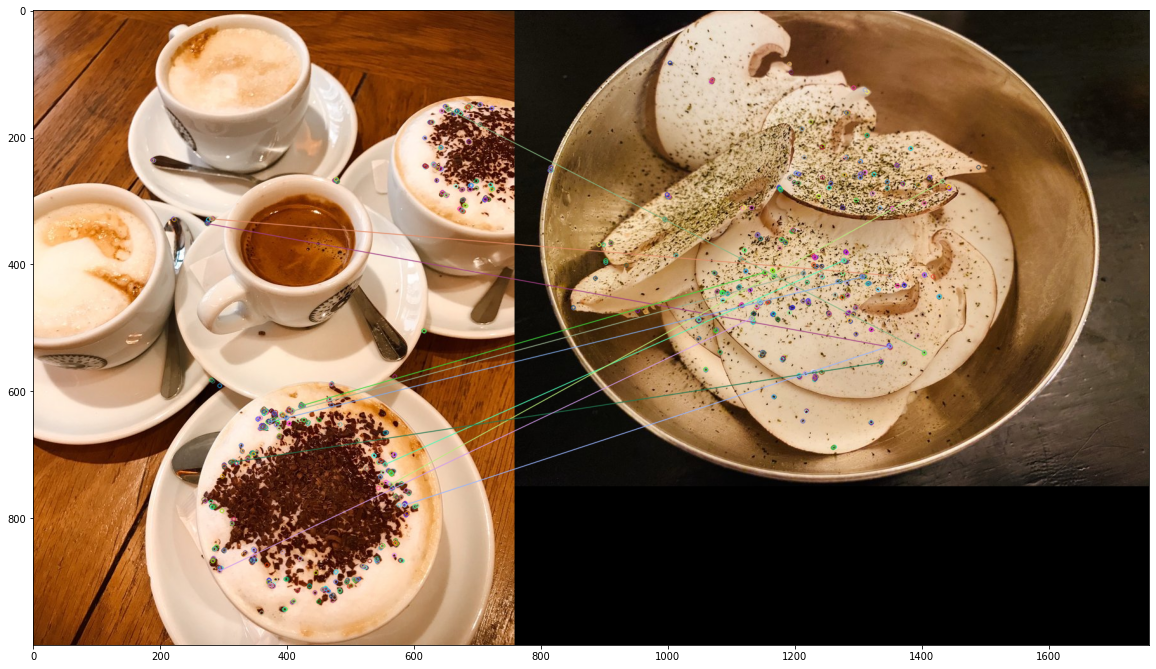

In [ ]:
import random


query_index = random.randint(0, len(photos_df) - 1)
print(query_index)
nn_index = orb_indices[query_index][1]

query_photo = photos_df.iloc[query_index]
query_img_path = os.path.join(data_path, "photos", query_photo["file_name"])
query_img = cv.cvtColor(
    cv.imread(query_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)

nn_photo = photos_df.iloc[nn_index]
nn_img_path = os.path.join(data_path, "photos", nn_photo["file_name"])
nn_img = cv.cvtColor(
    cv.imread(nn_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)


kp1 = photos_features_df.loc[query_index, "orb_keypoints"]
des1 = photos_features_df.loc[query_index, "orb_descriptors"]
kp2 = photos_features_df.loc[nn_index, "orb_keypoints"]
des2 = photos_features_df.loc[nn_index, "orb_descriptors"]


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(
    query_img,
    kp1,
    nn_img,
    kp2,
    good,
    None,
    # flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
fig = plt.figure(figsize=(20, 15))
plt.imshow(img3)
plt.show()


### Global features


In [ ]:
from skimage.feature import hog
import cv2 as cv


sizes = [2, 3, 5, 8, 13, 21]
size_photos_desc_df = pd.DataFrame(
    columns=[
        f"{size}_{color}_{i}_{j}"
        for size in sizes
        for color in [
            "red",
            "green",
            "blue",
            "hue",
            "saturation",
            "value",
            "lightness",
            "a",
            "b",
        ]
        for j in range(0, size)
        for i in range(0, size)
    ]
)

for photo in photos_df.itertuples():
    img_path = os.path.join(data_path, "photos", photo.file_name)
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)

    desc = []
    for size in sizes:
        img_res = cv.resize(img, (size, size))

        img_rgb = cv.cvtColor(img_res, cv.COLOR_BGR2RGB)
        red = img_rgb[:, :, 0].flatten()
        green = img_rgb[:, :, 1].flatten()
        blue = img_rgb[:, :, 2].flatten()

        img_hsv = cv.cvtColor(img_res, cv.COLOR_BGR2HSV)
        hue = img_hsv[:, :, 0].flatten()
        saturation = img_hsv[:, :, 1].flatten()
        value = img_hsv[:, :, 2].flatten()

        img_lab = cv.cvtColor(img_res, cv.COLOR_BGR2LAB)
        lightness = img_lab[:, :, 0].flatten()
        a = img_lab[:, :, 1].flatten()
        b = img_lab[:, :, 2].flatten()

        desc = np.concatenate(
            (desc, red, green, blue, hue, saturation, value, lightness, a, b)
        )

    size_photos_desc_df.loc[photo.file_name] = desc


size_photos_desc_df.describe()


2_red_0_0   2_red_1_0   2_red_0_1   2_red_1_1  2_green_0_0  \
count  999.000000  999.000000  999.000000  999.000000   999.000000   
mean   144.000000  140.318318  140.923924  140.845846   118.814815   
std     72.799433   73.120681   70.311476   73.090716    70.968725   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%     81.500000   75.000000   83.000000   77.000000    58.000000   
50%    155.000000  152.000000  150.000000  151.000000   118.000000   
75%    207.000000  204.000000  202.500000  206.000000   178.000000   
max    255.000000  255.000000  255.000000  255.000000   255.000000   

       2_green_1_0  2_green_0_1  2_green_1_1  2_blue_0_0  2_blue_1_0  ...  \
count   999.000000   999.000000   999.000000  999.000000  999.000000  ...   
mean    116.342342   112.512513   113.258258   95.518519   93.992993  ...   
std      70.514534    69.009261    71.288354   71.313847   70.872850  ...   
min       0.000000     0.000000     0.000000    0.000000    0.000000  ...   
25%      51.500000    54.000000    49.000000   32.000000   32.000000  ...   
50%     116.000000   109.000000   110.000000   82.000000   82.000000  ...   
75%     175.000000   169.000000   178.500000  152.000000  148.000000  ...   
max     255.000000   255.000000   255.000000  255.000000  255.000000  ...   

       21_b_11_20  21_b_12_20  21_b_13_20  21_b_14_20  21_b_15_20  21_b_16_20  \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean   140.573574  140.518519  140.620621  140.537538  140.604605  140.292292   
std     15.951340   16.657441   16.918857   16.335239   16.298162   16.052290   
min     68.000000   49.000000   42.000000   43.000000   45.000000   50.000000   
25%    130.000000  129.500000  129.000000  130.000000  129.000000  130.000000   
50%    138.000000  137.000000  137.000000  138.000000  137.000000  137.000000   
75%    149.000000  149.000000  149.000000  148.000000  149.000000  149.000000   
max    205.000000  200.000000  200.000000  200.000000  202.000000  203.000000   

       21_b_17_20  21_b_18_20  21_b_19_20  21_b_20_20  
count  999.000000  999.000000   999.00000  999.000000  
mean   140.783784  140.774775   140.94995  140.593594  
std     16.070464   15.878116    16.14791   15.692594  
min     58.000000   58.000000    57.00000   79.000000  
25%    130.000000  130.000000   130.00000  130.000000  
50%    138.000000  138.000000   138.00000  137.000000  
75%    150.000000  150.000000   150.00000  150.000000  
max    202.000000  202.000000   204.00000  207.000000  

[8 rows x 6408 columns]

In [ ]:
size_photos_desc_df.head()


2_red_0_0  2_red_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...      171.0      134.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       80.0      203.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...      227.0      117.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...      108.0       90.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...      248.0      152.0   

                                                    2_red_0_1  2_red_1_1  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...      103.0      173.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...      193.0       22.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       69.0      179.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...      116.0      225.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...      234.0      182.0   

                                                    2_green_0_0  2_green_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...         91.0         32.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...        127.0        203.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...        183.0        121.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...         99.0         90.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...        209.0         79.0   

                                                    2_green_0_1  2_green_1_1  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...         28.0        115.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...        131.0         23.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...         51.0        123.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...        103.0        187.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...        169.0        156.0   

                                                    2_blue_0_0  2_blue_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...        87.0        17.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       109.0       195.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       108.0       132.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...        92.0        66.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       130.0        55.0   

                                                    ...  21_b_11_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...  ...       131.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...  ...       134.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...  ...       136.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...  ...       138.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...  ...       153.0   

                                                    21_b_12_20  21_b_13_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       137.0       128.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       129.0       126.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       139.0       140.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...       139.0       137.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       153.0       153.0   

                                                    21_b_14_20  21_b_15_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       126.0       135.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       126.0       126.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       130.0       135.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...       138.0       138.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       154.0       155.0   

                                                    21_b_16_20  21_b_17_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       129.0       125.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       129.0       131.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       126.0       126.0   
l-avant-comptoir-paris-3_73670

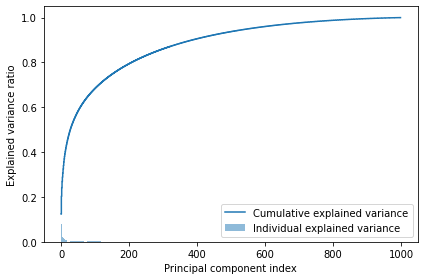

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
pca.fit(StandardScaler().fit_transform(size_photos_desc_df))
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


pca_size_photos_desc_df = PCA(n_components=10).fit_transform(
    StandardScaler().fit_transform(size_photos_desc_df)
)

# Create a nearest neighbor classifier
size_nbrs = NearestNeighbors(n_neighbors=2).fit(pca_size_photos_desc_df)


# Compute the distances between the query image and all images
size_distances, size_indices = size_nbrs.kneighbors(pca_size_photos_desc_df)


In [ ]:
fig = go.Figure(
    data=[
        go.Scatter(
            x=pca_size_photos_desc_df[:, 0],
            y=pca_size_photos_desc_df[:, 1],
            mode="markers",
            marker=dict(size=1, opacity=0.5),
        )
    ]
)

for i, photo in enumerate(photos_df.sample(100).itertuples()):
    # Add images
    fig.add_layout_image(
        dict(
            source=photo.photo_url,
            xref="x",
            yref="y",
            x=pca_size_photos_desc_df[i, 0],
            y=pca_size_photos_desc_df[i, 1],
            sizex=10,
            sizey=10,
        )
    )

fig.show()


78


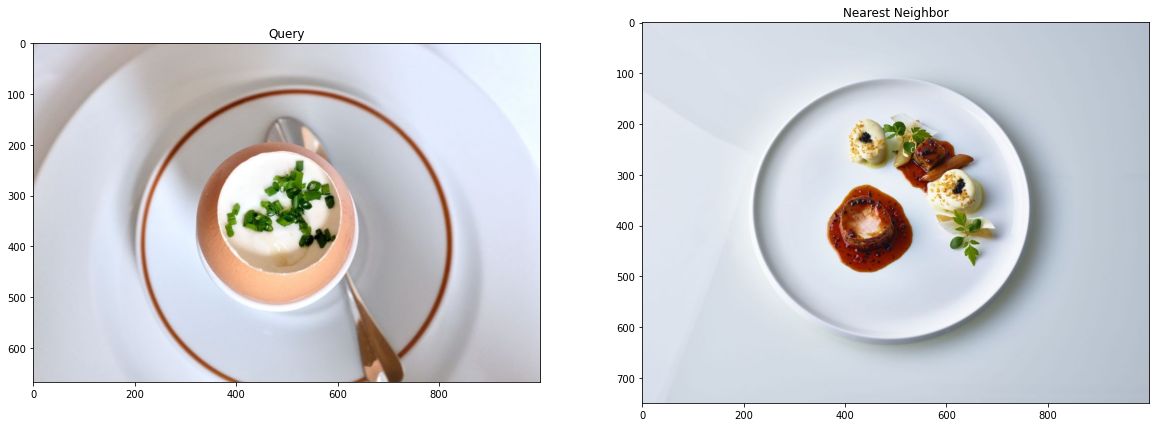

In [ ]:
import random


query_index = random.randint(0, len(photos_df) - 1)
print(query_index)
nn_index = size_indices[query_index][1]

query_photo = photos_df.iloc[query_index]
query_img_path = os.path.join(data_path, "photos", query_photo["file_name"])
query_img = cv.cvtColor(
    cv.imread(query_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)

nn_photo = photos_df.iloc[nn_index]
nn_img_path = os.path.join(data_path, "photos", nn_photo["file_name"])
nn_img = cv.cvtColor(
    cv.imread(nn_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)


# Plot the examples
fig = plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.imshow(query_img)
plt.title("Query")
plt.subplot(122)
plt.imshow(nn_img)
plt.title("Nearest Neighbor")
plt.show()


## CNN


2021-12-03 09:56:47.796378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-03 09:56:47.796422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-03 09:56:50.516502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-03 09:56:50.516762: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 09:56:50.516799: I tensorflow/stream_executor/cuda/cuda_diagno

Top 3 : [('n07695742', 'pretzel', 0.9991873), ('n07693725', 'bagel', 0.00031342733), ('n07697537', 'hotdog', 0.00017799396)]


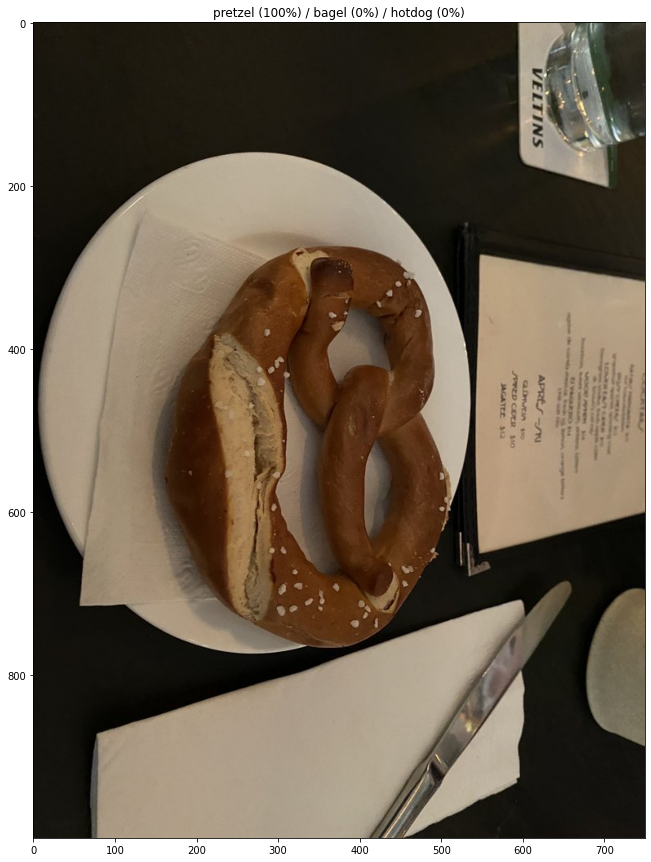

In [ ]:
photo = photos_df.sample().iloc[0]
img_path = os.path.join(data_path, "photos", photo["file_name"])


from keras.applications.vgg16 import VGG16

model = VGG16()  # Création du modèle VGG-16 implementé par Keras

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img(img_path, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape(
    (1, img.shape[0], img.shape[1], img.shape[2])
)  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

y = model.predict(
    img
)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print("Top 3 :", decode_predictions(y, top=3)[0])

predictions = decode_predictions(y, top=3)[0]
query_img = cv.cvtColor(
    cv.imread(img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)
plt.figure(figsize=(15, 15))
plt.imshow(query_img)
plt.title(
    f"{predictions[0][1]} ({round(100*predictions[0][2])}%) / {predictions[1][1]} ({round(100*predictions[1][2])}%) / {predictions[2][1]} ({round(100*predictions[2][2])}%)"
)
plt.show()
